In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import pandas as pd

from source_code.run_aggregation import run_aggregation
from source_code.run_all_models import run_all_models
from source_code.models import BalancePoint, DecayCurves, EnergyBalance

# Run the Gray Box Models

This noteboook is provided so that the code used in the paper can be run and tested with different datasets. For privacy reasons, we provide only a small subset of the ecobee data. To run with your own dataset, upload your own dataset into `data/raw_data`.

The code for this paper has been refactored so that it is easily readable in notebook format. If you'd like to dive deeper into the code, look into the `source_code` directory.

### 1. Setting up the models and the data filters

As discussed in the paper, the data filtering plays a large role in the results. The data filters for the models are defined as parameters. Refer to [models.py](models.py) to see a description of the parameters.

In [10]:
bp_model = BalancePoint()
dc_model = DecayCurves()
eb_model = EnergyBalance(print_times=False)

### 2. Load the data and prepare metadata

The directories specified below contain a subset of the data provided by ecobee so that you could interact with this notebook. Only a small subset of the data has been publicied for privacy reasons. Edit the file path to point to your own data directory. You can change these to match the column names in your data if you prefer, or preprocess your data to match our format

In [11]:
# Edit this path to point to your data.
data_directory = 'data/raw_data/buildings'

# The relevant data column names. 
T_out_col = 'Thermostat_Temperature'
T_in_col = 'T_out'
heat_col = 'auxHeat1'
heat_col_2 = 'auxHeat2'
dt_col = 'DateTime'
columns = (T_out_col, T_in_col, heat_col, heat_col_2, dt_col)

### 3. Preprocess the data

The only data preprocessing we do is changing Farenheight to Celsius and converting the heating runtime to a fraction between 0 and 1. Any other data preprocessing that you might like to try should be done here. Note that our data is recored in 5 minute intervals.

In [12]:
def preprocess(fname):
    # define preprocessing functions
    def FtoC(temperature):
        return (temperature-32.)*5./9.
    def normalize_runtime(runtime):
        return runtime/300.0
    # load the data
    df = pd.read_csv(fname, index_col=dt_col, parse_dates=[dt_col])
    # apply preprocessing functions
    df[[T_out_col, T_in_col]] = df[[T_out_col, T_in_col]].apply(FtoC)
    df[[heat_col, heat_col_2]] = df[[heat_col, heat_col_2]].apply(normalize_runtime)
    return df

### 4. Run the pipeline

You are now all set up to run the pipeline! You can execute it using the code below and the results will show up in the path specified by `results_directory`. Note that for some buildings some of the methods do not return any results. This is because of the filtering described in the paper.

In [29]:
results_directory = 'results'

run_all_models(
    bp_model, dc_model, eb_model, 
    data_directory, preprocess, results_directory, *columns)

Done!


### 5. Aggregate the results

Both the decay curve method and the energy balance method return many results for a given building and save them in raw csvs. The code below aggregates all the results and stores them in a summary csv. This summary csv will be used to analyze the results. Specify the location of the summary csv in the `summary_path` variable.

In [30]:
summary_path = 'summary.csv'
run_aggregation(results_directory, summary_path)

Done!


# Visualize the results

We have only provided you with a small subset of buildings to run the three gray box methods, but for visualization we have provided a summary csv that was created from the entire dataset, with the file names removed to retain anonymity. Note that the results of the model fitting are non-deterministic because the energy balance method selects intervals randomly. The results seen here may therefore be slightly different from those in the paper, but they are very similar and the conclusions remain the same.

As explained in the paper, the quality of results is suseptable to outliear removal. Try changing these values to see how the results change!

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats


plt.rcParams["patch.force_edgecolor"] = True

In [35]:
summary_df = pd.read_csv('summary_full_df.csv')
summary_no_outliers = summary_df.copy()

summary_no_outliers = summary_no_outliers[summary_no_outliers['euler_RC_std'] < 80 ]
summary_no_outliers = summary_no_outliers[summary_no_outliers['euler_RK_std'] < 125 ]
summary_no_outliers = summary_no_outliers[summary_no_outliers['euler_cost'] < 700]
summary_no_outliers = summary_no_outliers[summary_no_outliers['euler_amnt'] > 4]
summary_no_outliers = summary_no_outliers[summary_no_outliers['balance_stderr'] < 0.0015]
summary_no_outliers = summary_no_outliers[summary_no_outliers['balance_rvalue'] < -0.75]

In [36]:
len_no_outliers = len(summary_no_outliers)
len_total = len(summary_df)
len_percent = round((len(summary_no_outliers) / len(summary_df)) * 100, 2)

f'The initial dataset contained {len_total} buildings. After outlier removal, {len_percent} of the buildings are remaining.'

'The initial dataset contained 4646 buildings. After outlier removal, 30.89 of the buildings are remaining.'

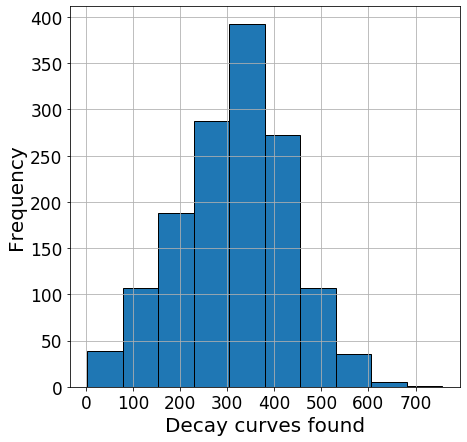

In [37]:
summary_no_outliers['decay_amnt'].plot(
    kind='hist', figsize=(7,7), grid=True, fontsize=17)
plt.xlabel('Decay curves found', fontsize=20)
plt.ylabel('Frequency', fontsize=20)

R value 0.6795518873072182


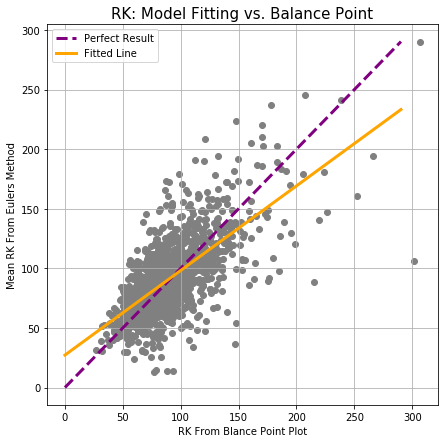

R value 0.7374289637899171


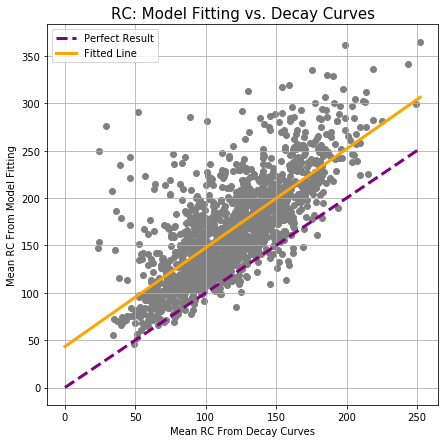

In [45]:
def plot_correlations(x_val, y_val, x_axis, y_axis, title, x_lim=None, y_lim=None):
    plt.figure(figsize=(7, 7))
    ax = plt.axes()
    
    mask = ~np.isnan(x_val) & ~np.isnan(y_val)
    line = stats.linregress(x_val[mask], y_val[mask])
    slope, intercept, r_value, p_value, std_err = line
    
    print('R value', r_value)
    
    ax.scatter(x_val, y_val, marker='o', color='grey')
    x = np.linspace(0, min(x_val.max(), y_val.max()), 1000)
    ax.plot(x, x, color='purple', label='Perfect Result',  ls='dashed', linewidth=3)
    ax.set_title(title, fontsize=15)
    ax.set_xlabel(x_axis)
    ax.set_ylabel(y_axis)
    if x_lim:
        plt.xlim(x_lim[0], x_lim[1])
    if y_lim:
        plt.ylim(y_lim[0], y_lim[1])
    ax.plot(x, intercept + slope*x, 'orange', label='Fitted Line', linewidth=3)
    plt.legend()
    plt.grid()
    plt.show()
    
# Plot the mean
plot_correlations(
    x_val=summary_no_outliers['balance_RK'], 
    y_val=summary_no_outliers['euler_RK_mean'],
    x_axis='RK From Blance Point Plot',
    y_axis='Mean RK From Eulers Method',
    title='RK: Model Fitting vs. Balance Point',
)

# Plot the Mean
plot_correlations(
    x_val=summary_no_outliers['decay_RC_mean'], 
    y_val=summary_no_outliers['euler_RC_mean'],
    x_axis='Mean RC From Decay Curves',
    y_axis='Mean RC From Model Fitting',
    title='RC: Model Fitting vs. Decay Curves',
)